In [38]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
import torch

from files.training import generate_data, generate_data_elliptic

from Base.lla import dgala
from Base.utilities import clear_hooks

# Burgers Eq

In [25]:
def plot_burgers(model,batch_size,in_out=[0.25,0.75],weighdecay=0., optimize=False):
    fig, axs = plt.subplots(2,2,figsize = (6,3), layout='constrained')
    X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction
    param_ =  (0.01/np.pi)

    path_model= f"./models/burgers_{{model}}_s{{bs}}_wd{weighdecay}.pth"
    path_dgala =  f"./models/burgers_ll_{{model}}_s{{bs}}_wd{weighdecay}.pth"

    fig.suptitle(f"{model}{'_optimized' if optimize else '_no_optimized'}_weight_decay{weighdecay}")

    for i,bs in enumerate(batch_size):
        burgers_model = torch.load(path_model.format(model = model,bs=bs))
        burgers_model.eval()

        llp = torch.load(path_dgala.format(model = model,bs=bs))
        llp.model.set_last_layer("output_layer")  # Re-register hooks

        llp.prior_precision = 1. if weighdecay==0. else weighdecay

        if optimize and weighdecay != 0.:
            llp.optimize_marginal_likelihood(max_iter=1000,error_tolerance=1e-9)
        elif optimize and weighdecay == 0.:
            llp.optimize_marginal_likelihoodb(max_iter=1000,error_tolerance=1e-9)

        for j,dt in enumerate(in_out):

            data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

            nn_pred = burgers_model.model(data_test)

            surg_mu, surg_sigma = llp(data_test)

            surg_mu = surg_mu[:,0].view(-1).detach().numpy()

            surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

            axs[i,j].plot(X, nn_pred.detach().numpy())
            axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
            axs[i,j].set_title(f"Burgers: {bs} at time {dt}")
    
    path = f"./results/burgers_{model}{"_optimized" if  optimize else ""}_wd{weighdecay}.png"

    plt.savefig(path)


Iteration 100, Error: 0.00665, neg_marglik: 1014.46313
Iteration 200, Error: 0.00146, neg_marglik: 978.13916
Iteration 300, Error: 0.00010, neg_marglik: 978.00262
Iteration 400, Error: 0.00000, neg_marglik: 978.00232
Iteration 100, Error: 0.00762, neg_marglik: 2023.27258
Iteration 200, Error: 0.00201, neg_marglik: 1657.90381
Iteration 300, Error: 0.00025, neg_marglik: 1657.52637
Iteration 400, Error: 0.00001, neg_marglik: 1657.52686
Iteration 100, Error: 0.00445, neg_marglik: 1235.72717
Iteration 200, Error: 0.00004, neg_marglik: 1214.79565
Iteration 100, Error: 0.00035, neg_marglik: 5652.38477
Iteration 200, Error: 0.00000, neg_marglik: 5652.12939
Iteration 100, Error: 0.00343, neg_marglik: 2775.22021
Iteration 200, Error: 0.00071, neg_marglik: 2773.76147
Iteration 300, Error: 0.00002, neg_marglik: 2773.74268
Iteration 100, Error: 0.00662, neg_marglik: 1922.37646
Iteration 200, Error: 0.00038, neg_marglik: 1511.24792
Iteration 300, Error: 0.00000, neg_marglik: 1511.24487
Iteration 100

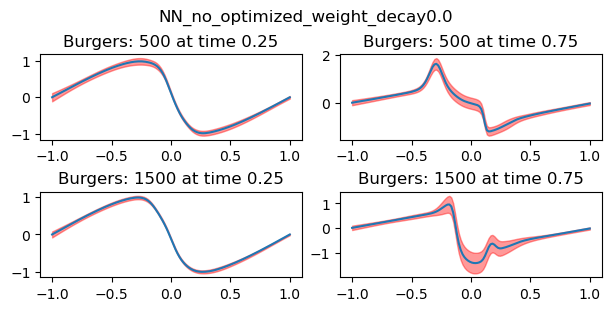

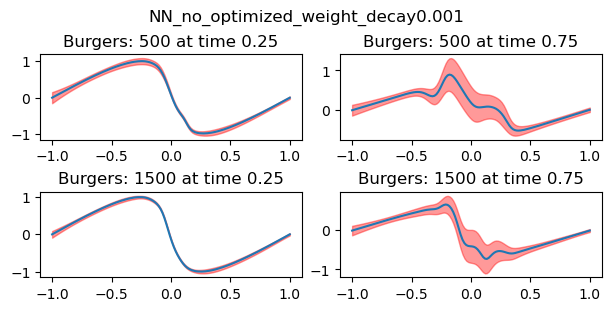

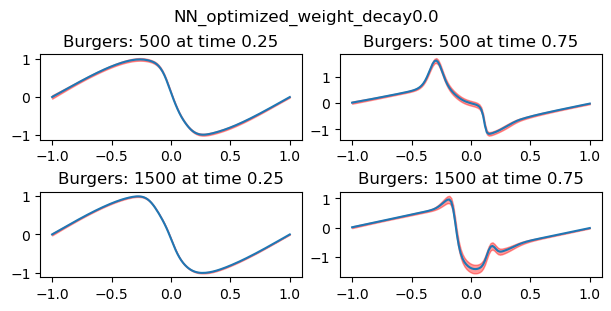

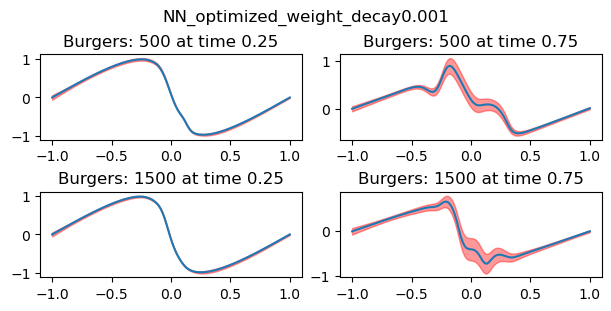

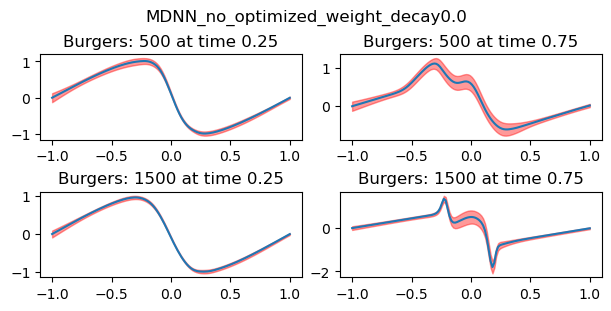

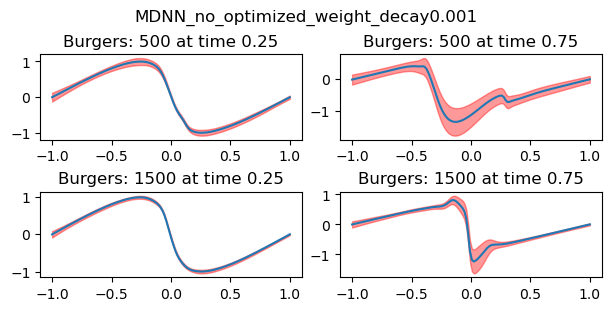

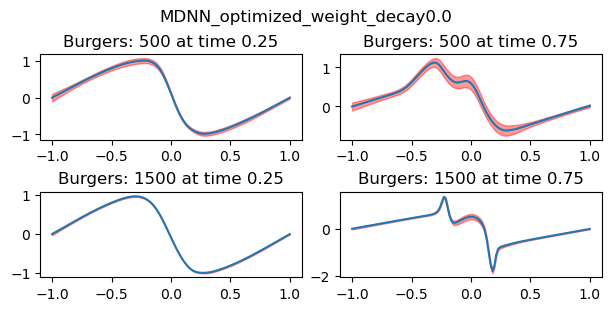

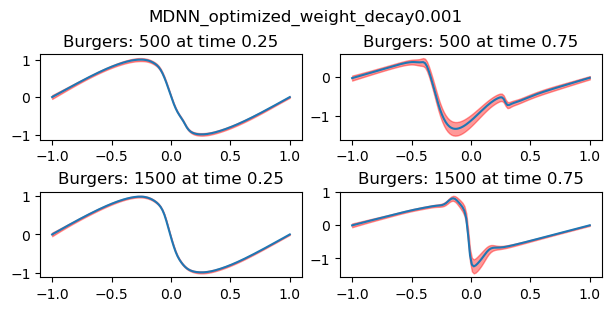

In [26]:
batch_size = [500,1500]
models = ["NN", "MDNN"]
optmized_ = [False,True]
wd = [0.,1e-3]
for mm in models:
    for opt in optmized_:
        for weight in wd:
             plot_burgers(mm,batch_size,in_out=[0.25,0.75],weighdecay=weight, optimize=opt)
            


# Heat

In [27]:
def plot_heat(model,batch_size,in_out=[0.25,0.75],weighdecay=0., optimize=False):
    fig, axs = plt.subplots(2,2,figsize = (6,3), layout='constrained')
    X = torch.linspace(0, 1, 128)  # Spatial grid in X direction
    param_ =  0.001

    path_model= f"./models/heat_{{model}}_s{{bs}}_wd{weighdecay}.pth"
    path_dgala =  f"./models/heat_ll_{{model}}_s{{bs}}_wd{weighdecay}.pth"

    fig.suptitle(f"{model}{'_optimized' if optimize else '_no_optimized'}_weight_decay{weighdecay}")

    for i,bs in enumerate(batch_size):
        burgers_model = torch.load(path_model.format(model = model,bs=bs))
        burgers_model.eval()

        llp = torch.load(path_dgala.format(model = model,bs=bs))
        llp.model.set_last_layer("output_layer")  # Re-register hooks
        llp.prior_precision = 1. if weighdecay==0. else weighdecay

        if optimize and weighdecay != 0.:
            llp.optimize_marginal_likelihood(max_iter=1000,error_tolerance=1e-9)
        elif optimize and weighdecay == 0.:
            llp.optimize_marginal_likelihoodb(max_iter=1000,error_tolerance=1e-9)

        for j,dt in enumerate(in_out):

            data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

            nn_pred = burgers_model.model(data_test)

            surg_mu, surg_sigma = llp(data_test)

            surg_mu = surg_mu[:,0].view(-1).detach().numpy()

            surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

            axs[i,j].plot(X, nn_pred.detach().numpy())
            axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
            axs[i,j].set_title(f"Heat: {bs} at time {dt}")
    
    path = f"./results/heat_{model}{"_optimized" if  optimize else ""}_wd{weighdecay}.png"

    plt.savefig(path)

NN False 0.0
NN False 0.001
NN True 0.0
Iteration 100, Error: 0.00576, neg_marglik: 15086.05859
Iteration 200, Error: 0.00376, neg_marglik: 9792.58203
Iteration 300, Error: 0.00275, neg_marglik: 8153.76221
Iteration 400, Error: 0.00213, neg_marglik: 7477.50635
Iteration 500, Error: 0.00171, neg_marglik: 7157.41504
Iteration 600, Error: 0.00141, neg_marglik: 6994.21924
Iteration 700, Error: 0.00117, neg_marglik: 6907.54004
Iteration 800, Error: 0.00099, neg_marglik: 6860.53027
Iteration 900, Error: 0.00084, neg_marglik: 6834.82861
Iteration 1000, Error: 0.00072, neg_marglik: 6820.77295
Maximum iterations (1000)reached, sigma : 6.511429309844971, prior: 0.03875639662146568.
Iteration 100, Error: 0.00529, neg_marglik: 16386.89258
Iteration 200, Error: 0.00311, neg_marglik: 15235.42773
Iteration 300, Error: 0.00210, neg_marglik: 15057.95703
Iteration 400, Error: 0.00157, neg_marglik: 15010.87500
Iteration 500, Error: 0.00126, neg_marglik: 14988.67578
Iteration 600, Error: 0.00106, neg_marg

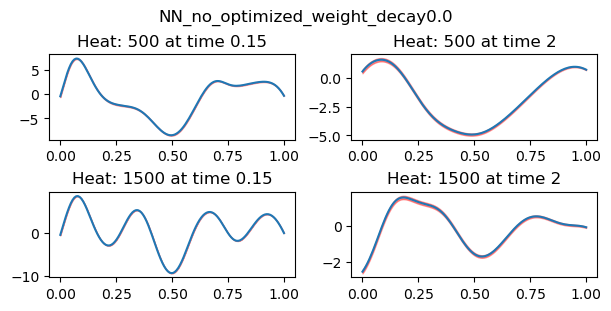

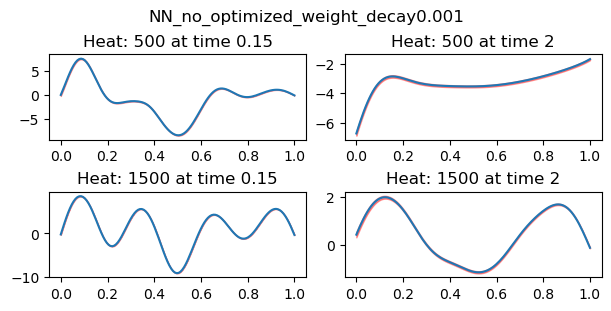

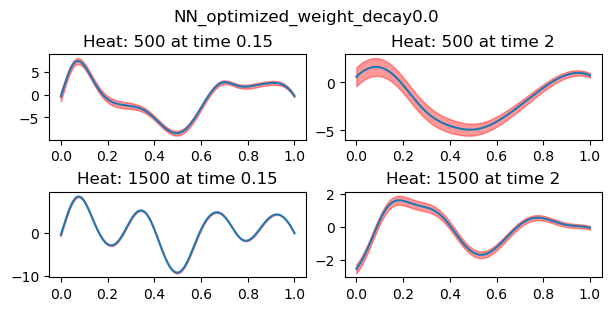

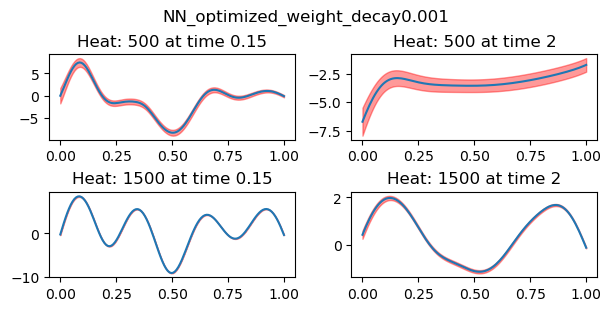

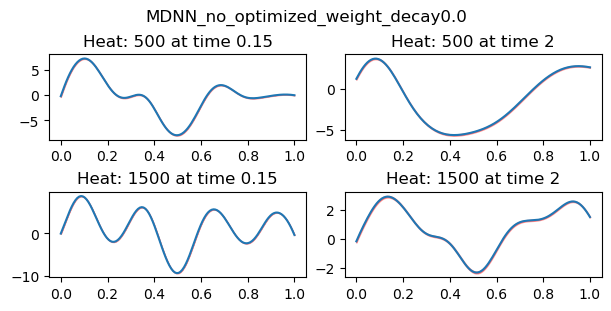

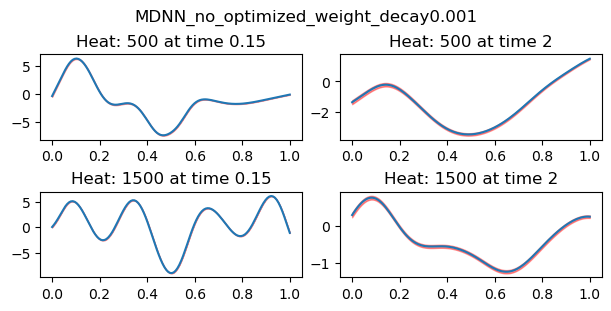

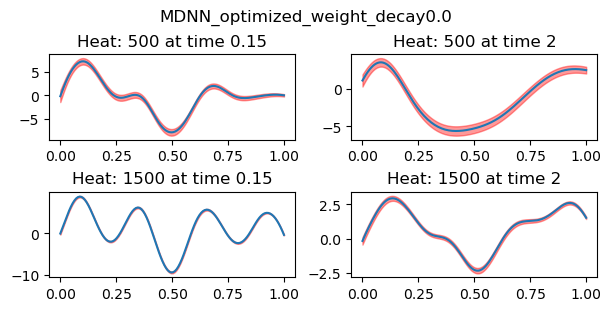

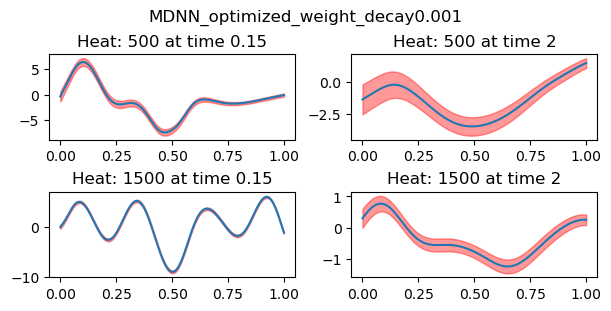

In [28]:
batch_size = [500,1500]
models = ["NN", "MDNN"]
optmized_ = [False,True]
wd = [0.,1e-3]
for mm in models:
    for opt in optmized_:
        for weight in wd:
             print(mm,opt,weight)
             plot_heat(mm,batch_size,in_out=[0.15,2],weighdecay=weight, optimize=opt)
            


# Elliptic

In [41]:
def plot_elliptic(model,batch_size,in_out=[(0.15,1.5),(2,2)],weighdecay=0., optimize=False):
    fig, axs = plt.subplots(2,2,figsize = (6,3), layout='constrained')
    X = torch.linspace(0, 1, 128)  # Spatial grid in X direction
    param_ =  0.001

    path_model= f"./models/elliptic_{{model}}_s{{bs}}_wd{weighdecay}.pth"
    path_dgala =  f"./models/elliptic_ll_{{model}}_s{{bs}}_wd{weighdecay}.pth"

    fig.suptitle(f"{model}{'_optimized' if optimize else '_no_optimized'}_weight_decay{weighdecay}")

    for i,bs in enumerate(batch_size):
        burgers_model = torch.load(path_model.format(model = model,bs=bs))
        burgers_model.eval()

        llp = torch.load(path_dgala.format(model = model,bs=bs))
        llp.model.set_last_layer("output_layer")  # Re-register hooks
        llp.prior_precision = 1. if weighdecay==0. else weighdecay

        if optimize and weighdecay != 0.:
            llp.optimize_marginal_likelihood(max_iter=1000,error_tolerance=1e-9)
        elif optimize and weighdecay == 0.:
            llp.optimize_marginal_likelihoodb(max_iter=1000,error_tolerance=1e-9)

        for j,dt in enumerate(in_out):

            data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * dt[0], torch.ones_like(X.reshape(-1,1)) * dt[1])).float()

            nn_pred = burgers_model.model(data_test)

            surg_mu, surg_sigma = llp(data_test)

            surg_mu = surg_mu[:,0].view(-1).detach().numpy()

            surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

            axs[i,j].plot(X, nn_pred.detach().numpy())
            axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
            axs[i,j].set_title(f"Elliptic: {bs} with param. {dt}")
    
    path = f"./results/elliptic_{model}{"_optimized" if  optimize else ""}_wd{weighdecay}.png"

    plt.savefig(path)

Iteration 100, Error: 0.00977, neg_marglik: 37.82542
Iteration 200, Error: 0.00882, neg_marglik: -389.97577
Iteration 300, Error: 0.00647, neg_marglik: -764.51282
Iteration 400, Error: 0.00253, neg_marglik: -941.10028
Iteration 500, Error: 0.00021, neg_marglik: -952.65125
Iteration 600, Error: 0.00001, neg_marglik: -952.67401
Iteration 700, Error: 0.00000, neg_marglik: -952.67401
Iteration 100, Error: 0.00968, neg_marglik: -437.55191
Iteration 200, Error: 0.00858, neg_marglik: -7916.80664
Iteration 300, Error: 0.00662, neg_marglik: -15352.75684
Iteration 400, Error: 0.00512, neg_marglik: -22498.95508
Iteration 500, Error: 0.00367, neg_marglik: -27952.25195
Iteration 600, Error: 0.00094, neg_marglik: -29430.38672
Iteration 700, Error: 0.00004, neg_marglik: -29463.80859
Iteration 800, Error: 0.00000, neg_marglik: -29463.84766
Iteration 100, Error: 0.00998, neg_marglik: 118.61971
Iteration 200, Error: 0.00983, neg_marglik: -302.43655
Iteration 300, Error: 0.00871, neg_marglik: -674.19403


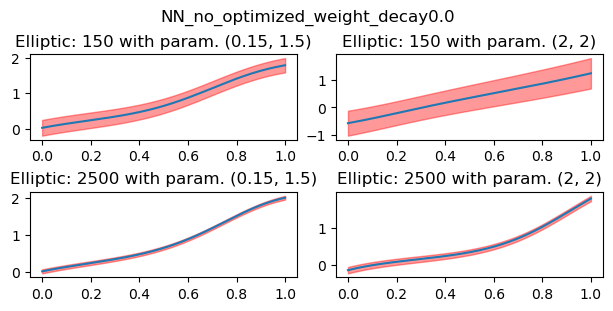

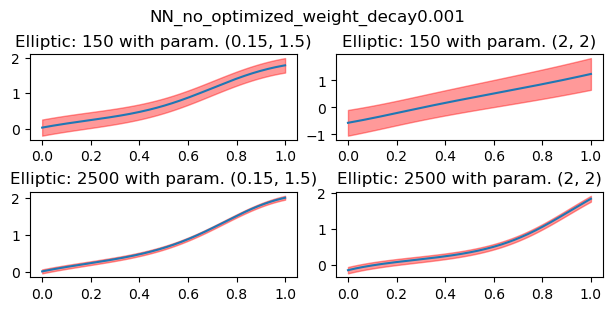

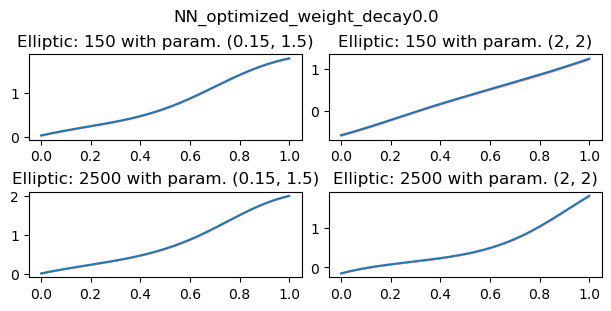

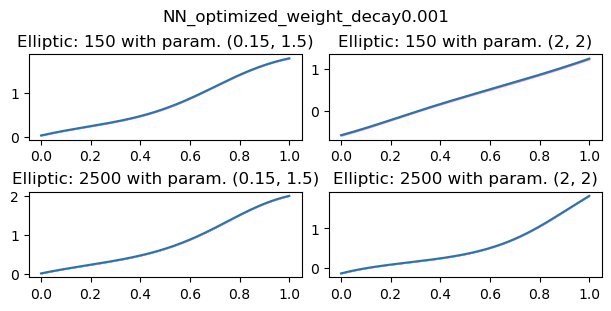

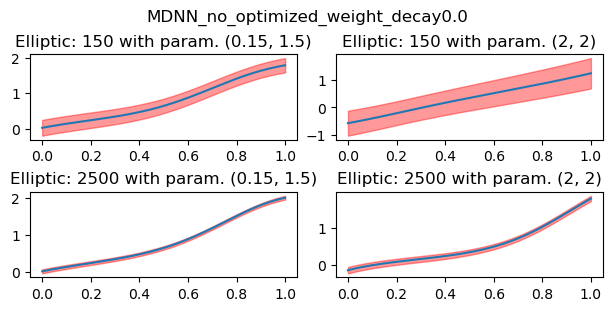

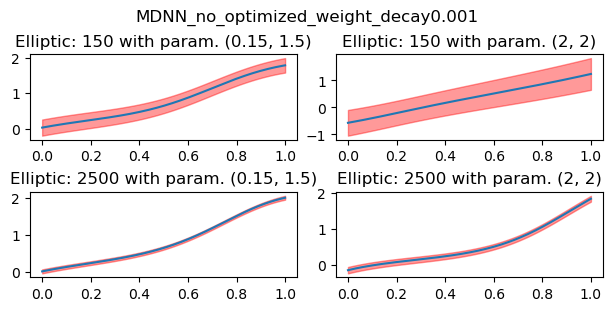

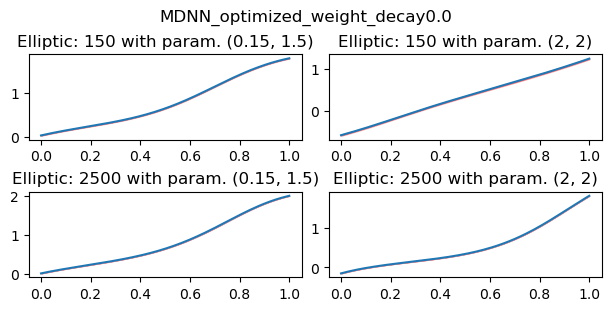

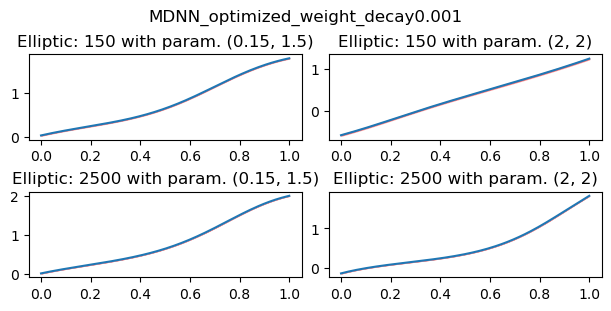

In [42]:
batch_size = [150,2500]
models = ["NN", "MDNN"]
optmized_ = [False,True]
wd = [0.,1e-3]
for mm in models:
    for opt in optmized_:
        for weight in wd:
             plot_elliptic(mm,batch_size,weighdecay=weight, optimize=opt)

# Laplace Approx Burgers Eq

In [2]:
dnn = True
path_models= f"./models/{'dnn_models/' if dnn else ''}Burgers_MDNN_s{{bs}}.pth"
path_dgala =  f"./models/dnn_models/burgers_lla_s{{bs}}.pth"
last_layer_name = 'output_layer'

In [5]:
batch_size = [500,1500]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 10, burgers=True)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["burgers_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["burgers"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    burgers_model = torch.load(path_models.format(bs=bs))
    burgers_model.eval()
    llp = dgala(burgers_model, prior_precision=1e-3)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, path_dgala.format(bs=bs))

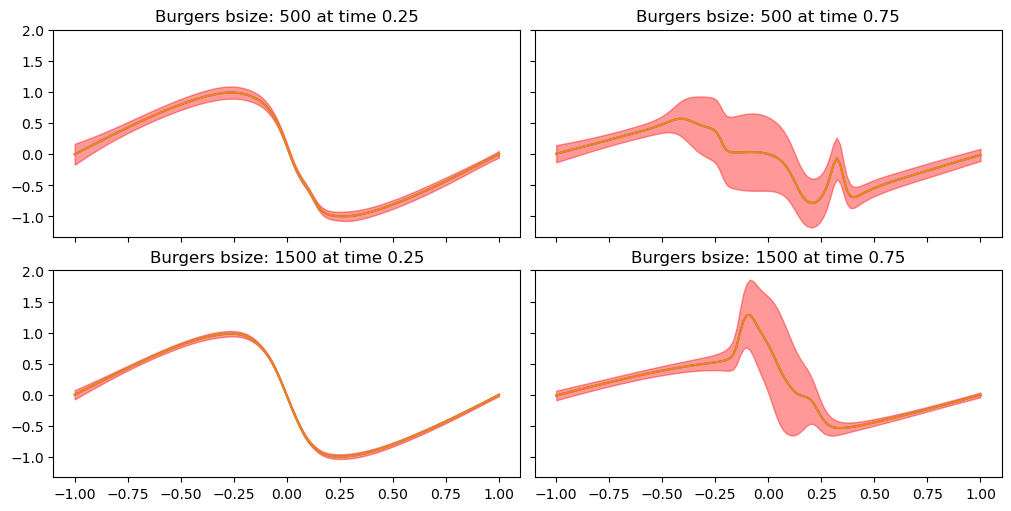

In [6]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)
batch_size = [500,1500]

for i,bs in enumerate(batch_size):
    
    burgers_model = torch.load(path_models.format(bs=bs))
    burgers_model.eval()

    llp = torch.load(path_dgala.format(bs=bs))
    llp.model.set_last_layer(last_layer_name)  # Re-register hooks

    for j,dt in enumerate([0.25,0.75]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = burgers_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].plot(X, surg_mu)

        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Burgers bsize: {bs} at time {dt}")

In [7]:
llp = torch.load(path_dgala.format(bs=500))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

llp.optimize_marginal_likelihood(max_iter=1000,error_tolerance=1e-9)
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00627, neg_marglik: 945.66229
Iteration 200, Error: 0.00003, neg_marglik: 857.49750
tensor(0.3300) tensor([0.0010])


Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

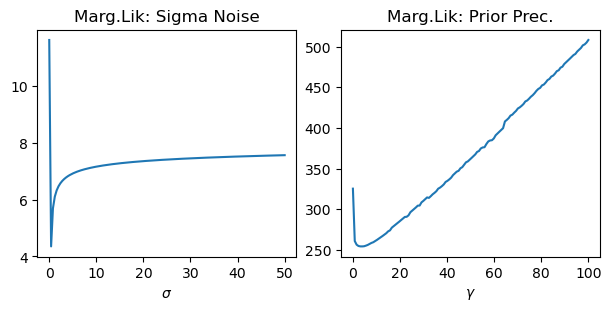

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(path_dgala.format(bs=100))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

sn = torch.linspace(0.01,50, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
#axs[0].axvline(llp.sigma_noise)
axs[0].set_xlabel(r"$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(path_dgala.format(bs=100))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

priorpre = torch.linspace(0.001,100, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
#axs[1].axvline(llp.prior_precision)
axs[1].set_xlabel(r"$\gamma$")
axs[1].set_title("Marg.Lik: Prior Prec.")


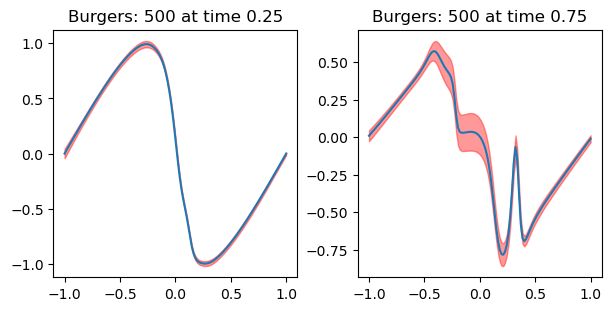

In [8]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(-1, 1, 128)  # Spatial grid in X direction

param_ =  (0.01/np.pi)

burgers_model = torch.load(path_models.format(bs=500))
burgers_model.eval()

# llp = torch.load(path_dgala.format(bs=100))
# llp.model.set_last_layer(last_layer_name)  # Re-register hooks

# llp.sigma_noise = 0.1674
llp.prior_precision = 10

for j,dt in enumerate([0.25,0.75]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

    nn_pred = burgers_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Burgers: {500} at time {dt}")

# Heat

In [6]:
dnn = True
path_models= f"./models/{'dnn_models/' if dnn else ''}Heat_MDNN_s{{bs}}.pth"
path_dgala =  f"./models/dnn_models/heat_lla_s{{bs}}.pth"


In [7]:
batch_size = [500,1500]

for i,bs in enumerate(batch_size):
    data_int,ini_c, left_bc, right_bc = generate_data(size=bs, nparam = 1, seed = 10, burgers=False)

    data_trainig = {"data_fit": {"pde":data_int, "ic_loss":ini_c,"bc_loss":(left_bc, right_bc)}, 
                    "class_method": {"pde": ["heat_pde"], "ic_loss":["u"], "bc_loss":["u","u"]},
                    "outputs": {"pde": ["heat"], "ic_loss": ["uic"],"bc_loss":["ubcl","ubcr"]}}

    heat_model = torch.load(path_models.format(bs=bs))
    heat_model.eval()

    llp = dgala(heat_model, prior_precision=1e-3)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, path_dgala.format(bs=bs))

FileNotFoundError: [Errno 2] No such file or directory: './models/dnn_models/Heat_MDNN_s500.pth'

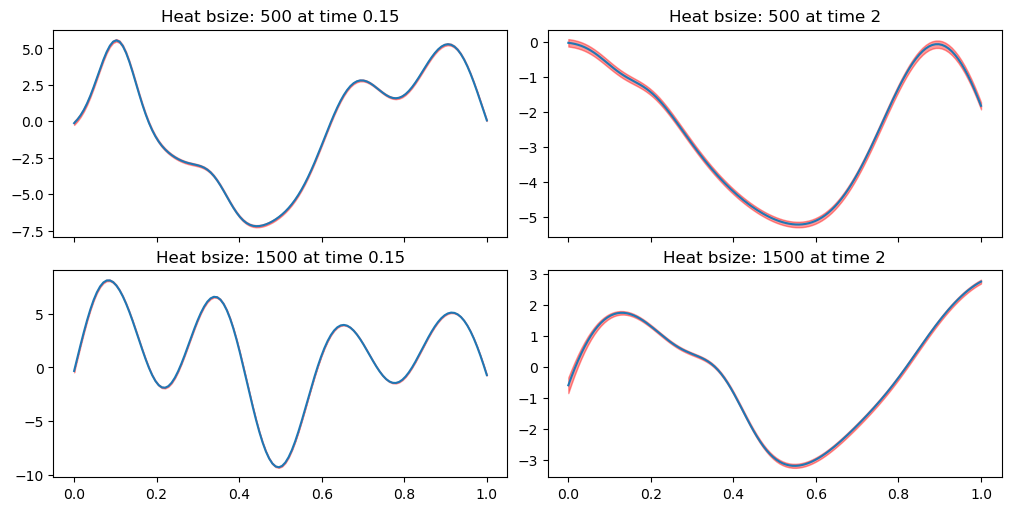

In [12]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001
batch_size = [500,1500]

for i,bs in enumerate(batch_size):

    heat_model = torch.load(path_models.format(bs=bs))
    heat_model.eval()

    llp = torch.load(path_dgala.format(bs=bs))
    llp.model.set_last_layer(last_layer_name)  # Re-register hooks

    for j,dt in enumerate([0.15,2]):
        data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()

        nn_pred = heat_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Heat bsize: {bs} at time {dt}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

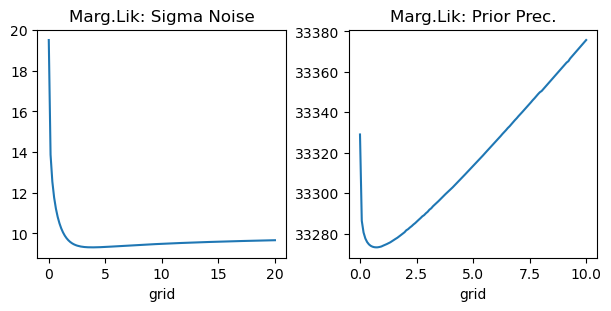

In [36]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(path_dgala.format(bs=1000))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

sn = torch.linspace(0.01,20, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(path_dgala.format(bs=1000))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

priorpre = torch.linspace(0.001,10, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")


In [13]:
llp = torch.load(path_dgala.format(bs=500))
llp.model.set_last_layer(last_layer_name)  # Re-register hooks

llp.optimize_marginal_likelihood()
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00486, neg_marglik: 38007.19531
Iteration 200, Error: 0.00294, neg_marglik: 20488.49219
Iteration 300, Error: 0.00210, neg_marglik: 14597.05957
Maximum iterations (300)reached, sigma : 3.8791515827178955, prior: 0.0010000000474974513.
tensor(3.8792) tensor([0.0010])


In [14]:
def exact_solution(x,t,theta):
    u = 4*np.sin(3*np.pi*x)*np.exp(-theta*((3*np.pi)**2)*t) + 9*np.sin(7*np.pi*x)*np.exp(-theta*((7*np.pi)**2)*t) + \
    (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)*np.exp(-theta*((5*np.pi)**2)*t) - (1/(25*(np.pi**2)*theta))*np.sin(5*np.pi*x)
    return u   

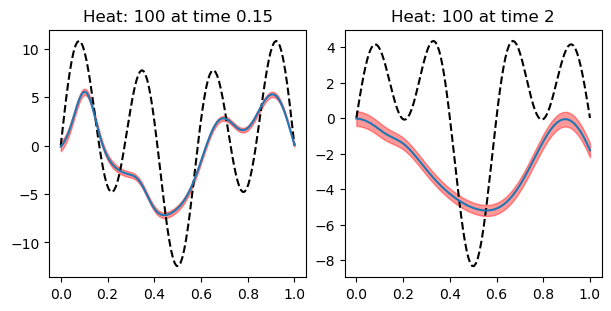

In [15]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

param_ =  0.001

heat_model = torch.load(path_models.format(bs=500))
heat_model.eval()

# llp = torch.load(path_dgala.format(bs=1000))
# llp.model.set_last_layer(last_layer_name)  # Re-register hooks

# llp.sigma_noise = 1.9579
# llp.prior_precision = [0.1754]

for j,dt in enumerate([0.15,2]):
    data_test = torch.hstack((X.reshape(-1,1),dt*torch.ones_like(X.reshape(-1,1)),param_*torch.ones_like(X.reshape(-1,1)))).float()
    exact_sol = exact_solution(X.numpy(), dt * np.ones_like(X.numpy()),param_)

    nn_pred = heat_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X,exact_sol,linestyle = "--",color = "black", label = "Exact Solution")
    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Heat: {100} at time {dt}")

# Elliptic

In [18]:
batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    data_int,left_bc,right_bc = generate_data_elliptic(size=150) 

    data_trainig = {"data_fit": {"pde":data_int, "left_bc":left_bc,"right_bc":right_bc}, 
                "class_method": {"pde": ["elliptic_pde"], "left_bc":["u"],"right_bc":["u"]},
                "outputs": {"pde": ["elliptic"], "left_bc": ["ubcl"],"right_bc":["ubcr"]}}
    
    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = dgala(elliptic_model, prior_precision=1e-3)

    llp.fit(data_trainig)
    # Before saving:
    clear_hooks(llp)
    torch.save(llp, f"./models/elliptic_lla_s{bs}.pth")

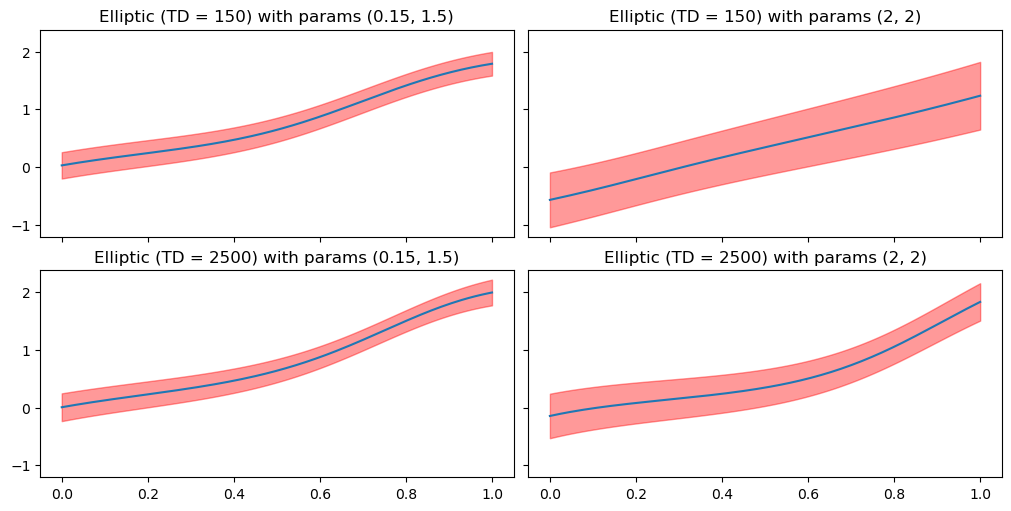

In [22]:
fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

batch_size = [150,2500]

for i,bs in enumerate(batch_size):

    elliptic_model = torch.load(f"./models/MDNN_s{bs}.pth")
    elliptic_model.eval()

    llp = torch.load(f"./models/elliptic_lla_s{bs}.pth")
    llp.model.set_last_layer("output_layer")  # Re-register hooks

    for j,pr in enumerate([(0.15,1.5),(2,2)]):

        data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()

        nn_pred = elliptic_model.model(data_test)

        surg_mu, surg_sigma = llp(data_test)

        surg_mu = surg_mu[:,0].view(-1).detach().numpy()

        surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

        axs[i,j].plot(X, nn_pred.detach().numpy())
        axs[i,j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
        axs[i,j].set_title(f"Elliptic (TD = {bs}) with params {pr}")

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

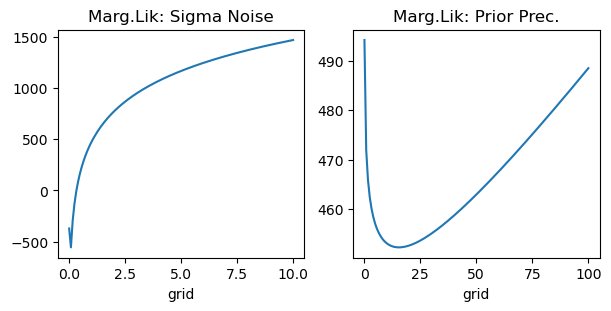

In [16]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(10, 0.01, 128)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,log_marg_lh)
axs[0].set_xlabel("grid")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(100, 0.1, 128)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [17]:
print(llp.sigma_noise,llp.prior_precision)

tensor(1.) tensor([[0.1000]])


In [20]:
llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.optimize_marginal_likelihood(max_iter=500)
print(llp.sigma_noise,llp.prior_precision)

Iteration 100, Error: 0.00998, neg_marglik: 118.61971
Iteration 200, Error: 0.00983, neg_marglik: -302.43655
Iteration 300, Error: 0.00871, neg_marglik: -674.19403
Iteration 400, Error: 0.00396, neg_marglik: -850.30383
tensor(0.0236) tensor([0.0010])


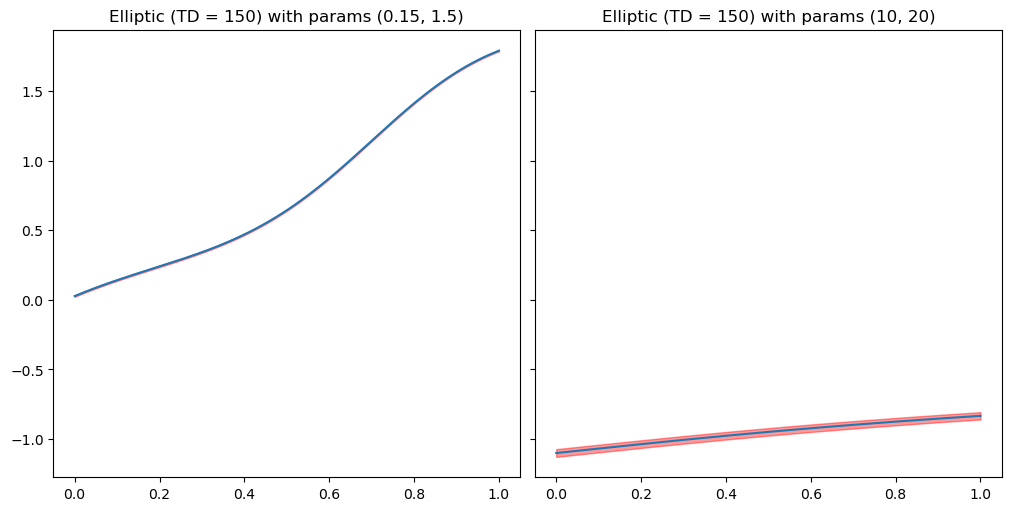

In [21]:
fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)
X = torch.linspace(0, 1, 128)  # Spatial grid in X direction

elliptic_model = torch.load(f"./models/MDNN_s{150}.pth")
elliptic_model.eval()
bs = 150
# llp = torch.load(f"./models/elliptic_lla_s{150}.pth")
# llp.model.set_last_layer("output_layer")  # Re-register hooks
# llp.sigma_noise = 0.0232
# llp.prior_precision = [16.2111]

for j,pr in enumerate([(0.15,1.5),(10,20)]):

    data_test = torch.hstack((X.reshape(-1,1), torch.ones_like(X.reshape(-1,1)) * pr[0], torch.ones_like(X.reshape(-1,1)) * pr[1])).float()

    nn_pred = elliptic_model.model(data_test)

    surg_mu, surg_sigma = llp(data_test)

    surg_mu = surg_mu[:,0].view(-1).detach().numpy()

    surg_sigma = surg_sigma[:, 0,0].sqrt().view(-1).detach().numpy()

    axs[j].plot(X, nn_pred.detach().numpy())
    axs[j].fill_between(X, surg_mu+surg_sigma,surg_mu-surg_sigma,alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
    axs[j].set_title(f"Elliptic (TD = {bs}) with params {pr}")